In [73]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()


Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16674910429883610434
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2915486926
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4252145598986020352
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:02:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

In [74]:
import os
import cv2
import glob
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
def rename(folder):
   
    for count, filename in enumerate(os.listdir(folder)):
        if count<10:
            new_name = f"00{str(count)}.jpg"
        elif count<100:
            new_name = f"0{str(count)}.jpg"
        else:
            new_name = f"{str(count)}.jpg"
            
        old_name =f"{folder}/{filename}"
        new_name =f"{folder}/{new_name}"

        os.rename(old_name, new_name)

In [ ]:
rename("C:/Users/Saberi/Desktop/NN/3/photos")

rename("C:/Users/Saberi/Desktop/NN/3/sketches")

In [75]:
photo_list = []

for filename in glob.glob('C:/Users/Saberi/Desktop/NN/3/photos/*.jpg'):
    im=cv2.imread(filename,0)
    im=cv2.resize(im, (120,144))
    photo_list.append(im)
    
sketch_list= []

for filename in glob.glob('C:/Users/Saberi/Desktop/NN/3/sketches/*.jpg'):
    im=cv2.imread(filename,0)
    im=cv2.resize(im, (120,144))
    sketch_list.append(im)

In [76]:
np.array(photo_list).shape

(188, 144, 120)

In [77]:
np.array(sketch_list).shape

(188, 144, 120)

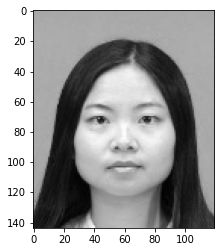

In [78]:
plt.imshow(photo_list[0],cmap='gray')
plt.show()

In [79]:
photo_arr=np.array(photo_list)
photo_arr.shape

(188, 144, 120)

In [80]:
photo_arr=photo_arr.reshape((188, 144, 120,1))
photo_arr.shape

(188, 144, 120, 1)

In [81]:
sketch_arr=np.array(sketch_list)
sketch_arr.shape

(188, 144, 120)

In [82]:
sketch_arr=sketch_arr.reshape((188, 144, 120,1))
sketch_arr.shape

(188, 144, 120, 1)

In [83]:
def get_gray_pic(photo,num1,num2,title):
    samp=(photo)[num1:num2]
    num=len(samp)
    fig, axes = plt.subplots(nrows=1, ncols=num,figsize=(15,15))
    for j in range(0,(num)):
        img = samp[j,:,:,0]
        axes[j].imshow(img,cmap='gray')
        axes[j].axis('off')
    
    axes[((num-1)//2)].set_title(f"{num} samples of {title}",loc='center')    

    plt.show()

In [9]:
def im_equalizer(image_arr):
 
    #flatten image array and calculate histogram 
    hist_arr = np.bincount(image_arr.flatten(), minlength=256)


    num_pxl = np.sum(hist_arr)
    hist_arr = hist_arr/num_pxl

    #normalized cumulative histogram
    cum_hist_array = np.cumsum(hist_arr)

    
    trans_arr = np.floor(255 * cum_hist_array).astype(np.uint8) #uint8 is an unsigned 8-bit integer that can represent values 0.. 255


    # flatten image array into list
    image_list = list(image_arr.flatten())

    # transform pixel values to equalize
    eq_image_list = [trans_arr[p] for p in image_list]

    # reshape and write back into img_array
    eq_image_arr = np.reshape(np.asarray(eq_image_list), image_arr.shape)
    return eq_image_arr


In [84]:
eq_photo=im_equalizer(photo_arr.astype("int64"))
eq_photo.shape

(188, 144, 120, 1)

In [85]:
uneq_eq_photo=np.concatenate((photo_arr,eq_photo))

In [86]:
uneq_uneq_sketch=np.concatenate((sketch_arr,sketch_arr))

In [87]:
print(uneq_eq_photo.shape, uneq_uneq_sketch.shape)

(376, 144, 120, 1) (376, 144, 120, 1)


In [88]:
flip_photo=np.concatenate((uneq_eq_photo,tf.image.flip_left_right(uneq_eq_photo)))

In [89]:
flip_sketch=np.concatenate((uneq_uneq_sketch,tf.image.flip_left_right(uneq_uneq_sketch)))

In [90]:
print(flip_photo.shape, flip_sketch.shape)

(752, 144, 120, 1) (752, 144, 120, 1)


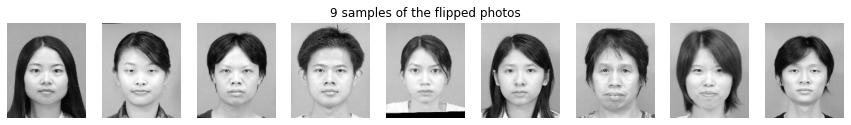

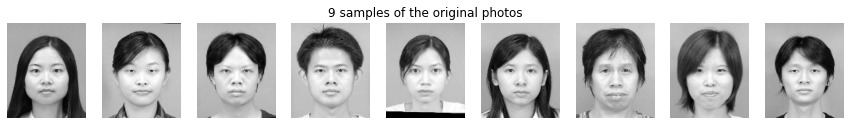

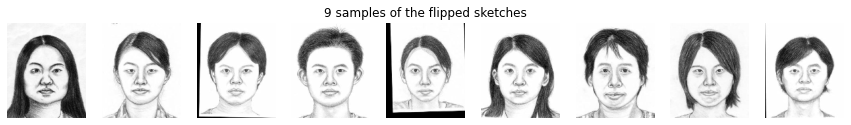

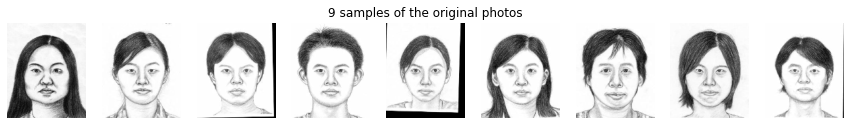

In [92]:
get_gray_pic(flip_photo,376,385,"the flipped photos")
get_gray_pic(uneq_eq_photo,0,9,"the original photos")
get_gray_pic(flip_sketch,376,385,"the flipped sketches")
get_gray_pic(uneq_uneq_sketch,0,9,"the original photos")

In [93]:
rot1_photo = np.concatenate((flip_photo,tfa.image.rotate(flip_photo, tf.constant(np.pi/8))))

In [94]:
rot1_sketch= np.concatenate((flip_sketch,tfa.image.rotate(flip_sketch, tf.constant(np.pi/8))))

In [95]:
print(rot1_photo.shape,rot1_sketch.shape)

(1504, 144, 120, 1) (1504, 144, 120, 1)


In [96]:
rot2_photo = np.concatenate((rot1_photo,tfa.image.rotate(flip_photo, tf.constant(-np.pi/8))))

In [97]:
rot2_sketch = np.concatenate((rot1_sketch,tfa.image.rotate(flip_sketch, tf.constant(-np.pi/8))))

In [98]:
print(rot2_photo.shape,rot2_sketch.shape)

(2256, 144, 120, 1) (2256, 144, 120, 1)


In [99]:
photo_shuffled,sketch_shuffled = shuffle(rot2_photo, rot2_sketch, random_state=0)

In [100]:
photo_shuffled=photo_shuffled/255.
sketch_shuffled=sketch_shuffled/255.

In [101]:
train_photo, test_photo, train_sketch, test_sketch = train_test_split(photo_shuffled, sketch_shuffled, test_size=0.01, random_state=42)

In [102]:
print(train_photo.shape)
print(train_sketch.shape)
print(test_photo.shape)
print(test_sketch.shape)

(2233, 144, 120, 1)
(2233, 144, 120, 1)
(23, 144, 120, 1)
(23, 144, 120, 1)


In [103]:
tf.config.experimental.get_memory_info('GPU:0')['current'] / 10**9

0.015308032

In [104]:
del photo_shuffled
del sketch_shuffled
del rot2_photo
del rot2_sketch
del rot1_photo
del rot1_sketch
del flip_photo
del flip_sketch
del photo_arr
del sketch_arr
del photo_list
del sketch_list
del uneq_eq_photo
del uneq_uneq_sketch
del eq_photo

In [105]:
tf.config.experimental.get_memory_info('GPU:0')['current'] / 10**9

0.015308032

___________

### Model fitting

In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D,Dropout,Input,Conv2DTranspose
from tensorflow.keras.optimizers import Adam

In [32]:
input = Input(shape=train_photo.shape[1:])

# Encoder
x = Conv2D(32, (5, 5), activation="relu", padding="same")(input)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.1)(x)

x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.1)(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.1)(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.1)(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = MaxPooling2D((2, 2))(x)



x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)
x = Dropout(0.1)(x)

# Decoder
x = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)

x = Conv2D(1, (5, 5), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
adam=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
autoencoder.compile(optimizer=adam, loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 144, 120, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 144, 120, 32)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 144, 120, 32)      9248      
                                                                 
 dropout (Dropout)           (None, 144, 120, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 120, 32)      9248      
                                                                 
 dropout_1 (Dropout)         (None, 144, 120, 32)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 144, 120, 32)      9248  

In [34]:
history = autoencoder.fit(x=train_photo,y=train_sketch,epochs=1000,batch_size = 32, validation_split= 0.01)

Epoch 1/1000
70/70 [==============================] - 25s 331ms/step - loss: 0.6276 - val_loss: 0.4941
Epoch 2/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.3893 - val_loss: 0.3658
Epoch 3/1000
70/70 [==============================] - 22s 308ms/step - loss: 0.3452 - val_loss: 0.3549
Epoch 4/1000
70/70 [==============================] - 22s 308ms/step - loss: 0.3359 - val_loss: 0.3684
Epoch 5/1000
70/70 [==============================] - 22s 308ms/step - loss: 0.3313 - val_loss: 0.3450
Epoch 6/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.3246 - val_loss: 0.3377
Epoch 7/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.3209 - val_loss: 0.3256
Epoch 8/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.3172 - val_loss: 0.3215
Epoch 9/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.3148 - val_loss: 0.3195
Epoch 10/1000
70/70 [==============================] - 22s 309ms/step - l

Epoch 80/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.2746 - val_loss: 0.2930
Epoch 81/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.2744 - val_loss: 0.2944
Epoch 82/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.2731 - val_loss: 0.2903
Epoch 83/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.2727 - val_loss: 0.2885
Epoch 84/1000
70/70 [==============================] - 23s 325ms/step - loss: 0.2722 - val_loss: 0.2934
Epoch 85/1000
70/70 [==============================] - 22s 310ms/step - loss: 0.2720 - val_loss: 0.2913
Epoch 86/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.2718 - val_loss: 0.2871
Epoch 87/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.2731 - val_loss: 0.2897
Epoch 88/1000
70/70 [==============================] - 22s 309ms/step - loss: 0.2723 - val_loss: 0.2901
Epoch 89/1000
70/70 [==============================] - 22s 309ms

70/70 [==============================] - 21s 306ms/step - loss: 0.2637 - val_loss: 0.2737
Epoch 237/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2618 - val_loss: 0.2699
Epoch 238/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2598 - val_loss: 0.2687
Epoch 239/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2591 - val_loss: 0.2683
Epoch 240/1000
70/70 [==============================] - 21s 307ms/step - loss: 0.2588 - val_loss: 0.2675
Epoch 241/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2587 - val_loss: 0.2671
Epoch 242/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2585 - val_loss: 0.2675
Epoch 243/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2590 - val_loss: 0.2672
Epoch 244/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2588 - val_loss: 0.2678
Epoch 245/1000
70/70 [==============================] - 21s 306ms/step

70/70 [==============================] - 21s 306ms/step - loss: 0.2571 - val_loss: 0.2642
Epoch 393/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2569 - val_loss: 0.2641
Epoch 394/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2572 - val_loss: 0.2643
Epoch 395/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2568 - val_loss: 0.2643
Epoch 396/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2567 - val_loss: 0.2639
Epoch 397/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2567 - val_loss: 0.2637
Epoch 398/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2567 - val_loss: 0.2636
Epoch 399/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2569 - val_loss: 0.2655
Epoch 400/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2584 - val_loss: 0.2653
Epoch 401/1000
70/70 [==============================] - 21s 306ms/step

70/70 [==============================] - 21s 306ms/step - loss: 0.2557 - val_loss: 0.2621
Epoch 549/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2557 - val_loss: 0.2631
Epoch 550/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2558 - val_loss: 0.2622
Epoch 551/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2557 - val_loss: 0.2629
Epoch 552/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2559 - val_loss: 0.2621
Epoch 553/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2574 - val_loss: 0.2695
Epoch 554/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2632 - val_loss: 0.2702
Epoch 555/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2586 - val_loss: 0.2649
Epoch 556/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2579 - val_loss: 0.2634
Epoch 557/1000
70/70 [==============================] - 21s 306ms/step

70/70 [==============================] - 21s 306ms/step - loss: 0.2553 - val_loss: 0.2621
Epoch 705/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2552 - val_loss: 0.2624
Epoch 706/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2552 - val_loss: 0.2622
Epoch 707/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2552 - val_loss: 0.2623
Epoch 708/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2552 - val_loss: 0.2620
Epoch 709/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2551 - val_loss: 0.2622
Epoch 710/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2551 - val_loss: 0.2627
Epoch 711/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2552 - val_loss: 0.2618
Epoch 712/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2551 - val_loss: 0.2618
Epoch 713/1000
70/70 [==============================] - 21s 306ms/step

70/70 [==============================] - 21s 306ms/step - loss: 0.2561 - val_loss: 0.2924
Epoch 861/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2663 - val_loss: 0.2663
Epoch 862/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2574 - val_loss: 0.2625
Epoch 863/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2560 - val_loss: 0.2618
Epoch 864/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2556 - val_loss: 0.2613
Epoch 865/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2554 - val_loss: 0.2618
Epoch 866/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2552 - val_loss: 0.2615
Epoch 867/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2553 - val_loss: 0.2614
Epoch 868/1000
70/70 [==============================] - 21s 306ms/step - loss: 0.2552 - val_loss: 0.2611
Epoch 869/1000
70/70 [==============================] - 21s 306ms/step

In [35]:
pred= autoencoder.predict(test_photo)

1/1 [==============================] - 0s 268ms/step


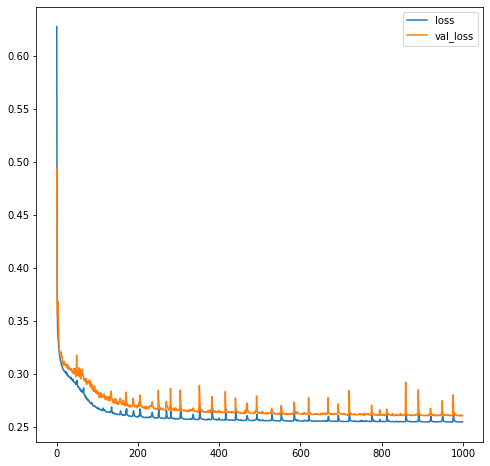

In [38]:
plt.figure(figsize=(8,8))
plt.plot(history.history["loss"][::])
plt.plot(history.history["val_loss"][::])
plt.legend(["loss","val_loss"])
plt.show()

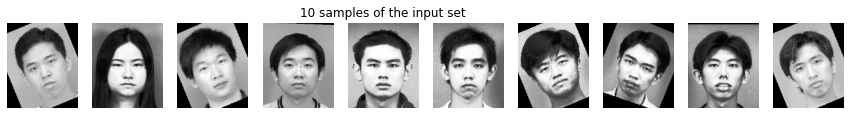

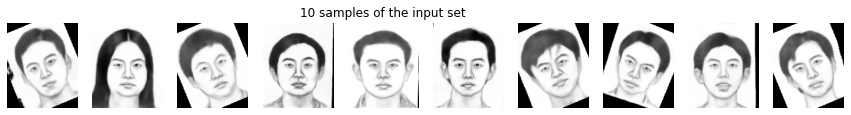

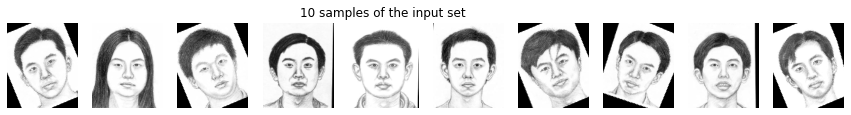

In [37]:
get_gray_pic(test_photo,0,10)
get_gray_pic(pred,0,10)
get_gray_pic(test_sketch,0,10)

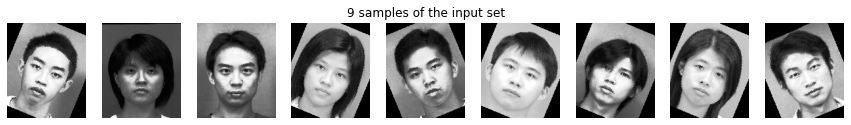

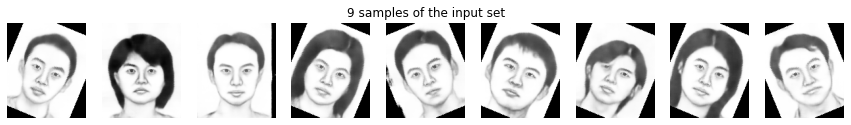

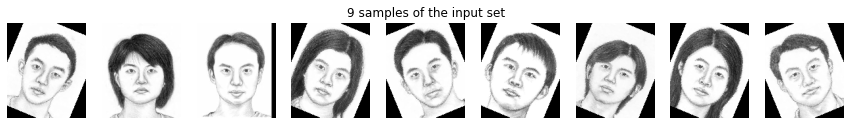

In [40]:
get_gray_pic(test_photo,11,20)
get_gray_pic(pred,11,20)
get_gray_pic(test_sketch,11,20)

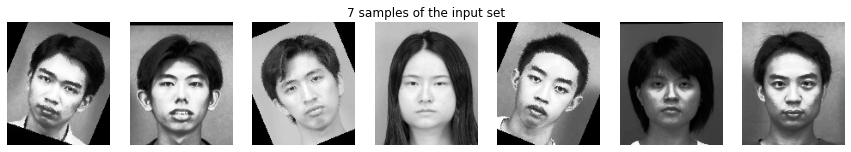

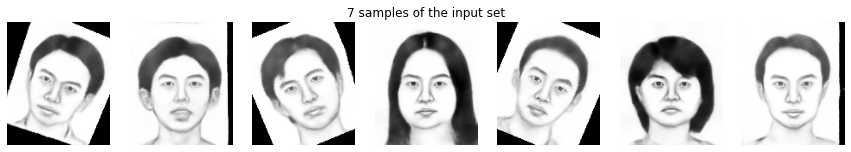

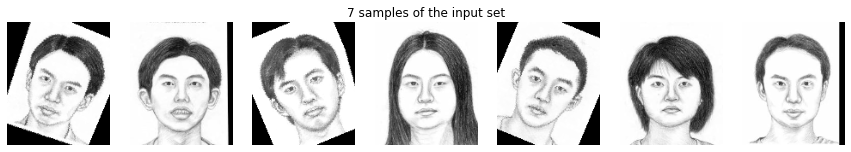

In [70]:
get_gray_pic(test_photo,7,14)
get_gray_pic(pred,7,14)
get_gray_pic(test_sketch,7,14)